In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

In [350]:
df=pd.read_csv("daily cases.csv")
df.shape

(207, 3)

## For China

In [351]:
df_c=df.iloc[-196:,:2]
df_c.shape

(196, 2)

In [352]:
df_c.head()

,Date,China
11,2020-02-03,3086
12,2020-02-04,3991
13,2020-02-05,3733
14,2020-02-06,3147
15,2020-02-07,3523


In [353]:
## set the date to the datetime form and set them as index
df_c.Date = pd.to_datetime(df_c.Date)
df_c =df_c.set_index("Date")

In [354]:
df_c.head()

,China
Date,
2020-02-03,3086
2020-02-04,3991
2020-02-05,3733
2020-02-06,3147
2020-02-07,3523


In [355]:
## split the train and test data
train_c, test_c = df_c[:-30],df_c[-30:]
## Set the scaler
scaler=MinMaxScaler()
scaler.fit(train_c)
train_c=scaler.transform(train_c)
test_C=scaler.transform(test_c)

In [356]:
n_input = 14
n_features=1

generator =TimeseriesGenerator(train_c,train_c,length=n_input,batch_size=6)

In [357]:
## build LSTM
model = Sequential()
model.add(LSTM(150,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(150,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(50,activation='relu', input_shape=(n_input,n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")


history =model.fit_generator(generator,epochs=180)

Epoch 1/180
26/26 [==============================] - 0s 13ms/step - loss: 3.0369e-04
Epoch 2/180
26/26 [==============================] - 0s 11ms/step - loss: 2.6157e-04
Epoch 3/180
26/26 [==============================] - 0s 12ms/step - loss: 1.9546e-04
Epoch 4/180
26/26 [==============================] - 0s 11ms/step - loss: 3.9007e-04
Epoch 5/180
26/26 [==============================] - 0s 11ms/step - loss: 1.9759e-04
Epoch 6/180
26/26 [==============================] - 0s 11ms/step - loss: 1.5624e-04
Epoch 7/180
26/26 [==============================] - 0s 11ms/step - loss: 1.5039e-04
Epoch 8/180
26/26 [==============================] - 0s 11ms/step - loss: 1.5296e-04
Epoch 9/180
26/26 [==============================] - 0s 12ms/step - loss: 1.8021e-04
Epoch 10/180
26/26 [==============================] - 0s 11ms/step - loss: 2.0171e-04
Epoch 11/180
26/26 [==============================] - 0s 12ms/step - loss: 1.5986e-04
Epoch 12/180
26/26 [==============================] - 0s 11ms/s

In [358]:
## do the fitting
fit_list = []
batch_fit = train_c[:n_input].reshape(1, n_input,n_features)

train_c_list = train_c.tolist()

train_c_list[1]
for i in range(152):
    fit_list.append(model.predict(batch_fit)[0])
    batch_fit = np.append(batch_fit[:,1:,:], [[train_c_list[n_input+i]]],axis=1)

In [359]:
pred_list =[]
batch =train_c[-n_input:].reshape(1,n_input,n_features)

## Do 30 predictions
for i in range(30):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:], [[pred_list[i]]],axis=1)


In [360]:
# inverse the scaler (change to the real values), and the make the value to a dataframe
df_predict_c = pd.DataFrame(scaler.inverse_transform(pred_list),index=df_c[-30:].index,columns=["Prediction_China"])
df_fitted_c = pd.DataFrame(scaler.inverse_transform(fit_list),index=df_c[14:-30].index,columns=["Fitted_China"])
# concatnate the predicted value with the real values
df_test_c = pd.concat([df_c,df_predict_c,df_fitted_c], axis=1)
# test the result data

In [361]:
#df_test_c.tail(30)

## Plot

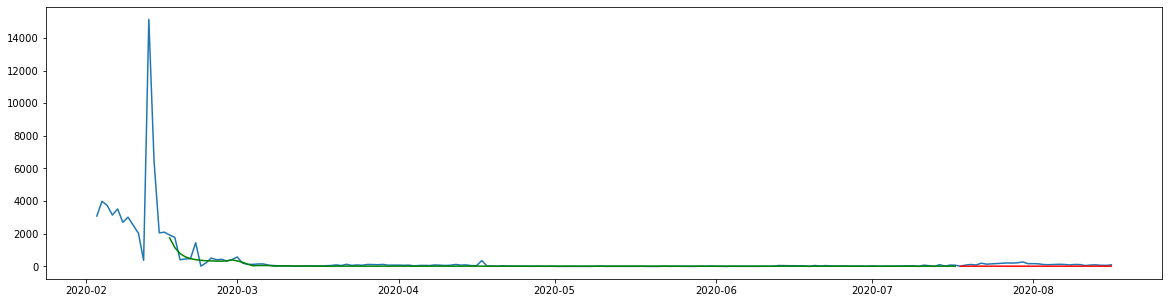

In [362]:
## visulisation
plt.figure(figsize=(20,5))
plt.plot(df_test_c.index,df_test_c["China"],label="True Value")
plt.plot(df_test_c.index,df_test_c["Prediction_China"],color="r",label="Prediction")
plt.plot(df_test_c.index,df_test_c["Fitted_China"],color="g",label="Fitted Value")
plt.title("Daily New Comfirmed Cases in China")
plt.legend(loc="upper right")
plt.show()

In [363]:
df_mse_c=df_test_c[-30:]
rmse_c= ((df_mse_c.China - df_mse_c.Prediction_China) ** 2).mean() ** .5
print("Total loss on China prediction is",rmse_c)

Total loss on China prediction is 129.23590265143756


### Experiments
  
| Prediction Window | Layers |Hidden States| RMSE |
| --- | --- | --- |---|
| 30 | 1 |100|130.20|
| 30 | 2 |100|104.89|
| 30 | 3 |100|109.82|
| 30 | 1 |70|131.39|
| 30 | 2 |70|118.49|
| 30 | 3 |70|118.30|
| 30 | 4 |50|103.23|
| 30 | 3 |150/150/50|129.24|

## For USA

In [455]:
df_us=df.drop("China", axis=1)
df_us = df_us.iloc[-196:,:2]
df_us.head()

,Date,USA
11,2020-02-03,3
12,2020-02-04,0
13,2020-02-05,0
14,2020-02-06,0
15,2020-02-07,0


In [456]:
df_us.Date = pd.to_datetime(df_us.Date)
df_us =df_us.set_index("Date")
## split the train and test data
train_us, test_us = df_us[:-30],df_us[-30:]
## Set the scaler
scaler=MinMaxScaler()
scaler.fit(train_us)
train_us=scaler.transform(train_us)
test_us=scaler.transform(test_us)

n_input = 14
n_features=1

generator =TimeseriesGenerator(train_us,train_us,length=n_input,batch_size=6)

## build LSTM
model = Sequential()
model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features),return_sequences=True))
model.add(LSTM(100,activation='relu', input_shape=(n_input,n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

model.fit_generator(generator,epochs=180)

Epoch 1/180
26/26 [==============================] - 1s 29ms/step - loss: 0.0855
Epoch 2/180
26/26 [==============================] - 1s 26ms/step - loss: 0.0637
Epoch 3/180
26/26 [==============================] - 1s 25ms/step - loss: 0.0703
Epoch 4/180
26/26 [==============================] - 1s 25ms/step - loss: 0.0552
Epoch 5/180
26/26 [==============================] - 1s 24ms/step - loss: 0.0592
Epoch 6/180
26/26 [==============================] - 1s 24ms/step - loss: 0.0387
Epoch 7/180
26/26 [==============================] - 1s 26ms/step - loss: 0.5014
Epoch 8/180
26/26 [==============================] - 1s 25ms/step - loss: 0.0556
Epoch 9/180
26/26 [==============================] - 1s 25ms/step - loss: 0.0512
Epoch 10/180
26/26 [==============================] - 1s 26ms/step - loss: 0.0408
Epoch 11/180
26/26 [==============================] - 1s 26ms/step - loss: 0.0230
Epoch 12/180
26/26 [==============================] - 1s 26ms/step - loss: 0.0679
Epoch 13/180
26/26 [=====

In [457]:
## do the fitting
fit_list = []
batch_fit = train_us[:n_input].reshape(1, n_input,n_features)

train_us_list = train_us.tolist()

train_us_list[1]
for i in range(152):
    fit_list.append(model.predict(batch_fit)[0])
    batch_fit = np.append(batch_fit[:,1:,:], [[train_us_list[n_input+i]]],axis=1)
    
pred_list =[]
batch =train_us[-n_input:].reshape(1,n_input,n_features)

## Do 30 predictions
for i in range(30):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:], [[pred_list[i]]],axis=1)

# inverse the scaler (change to the real values), and the make the value to a dataframe
df_predict_us = pd.DataFrame(scaler.inverse_transform(pred_list),index=df_us[-30:].index,columns=["Prediction_USA"])
df_fitted_us = pd.DataFrame(scaler.inverse_transform(fit_list),index=df_us[14:-30].index,columns=["Fitted_USA"])
# concatnate the predicted value with the real values
df_test_us = pd.concat([df_us,df_predict_us,df_fitted_us], axis=1)

### Plot

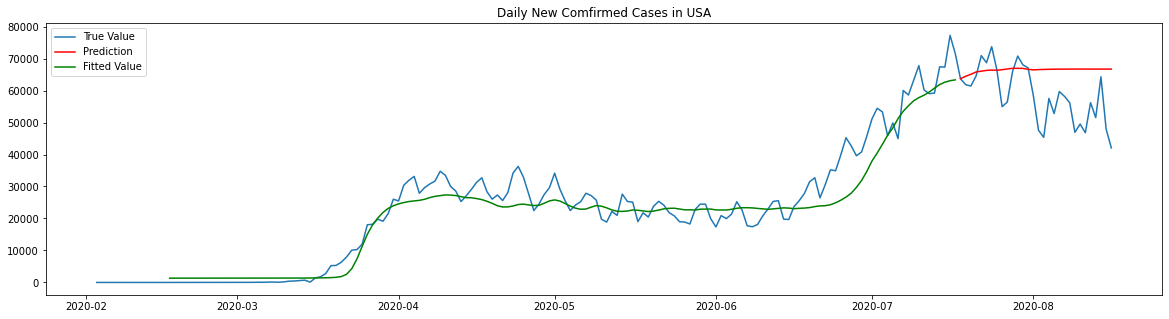

In [458]:
## visulisation
plt.figure(figsize=(20,5))
plt.plot(df_test_us.index,df_test_us["USA"],label="True Value")
plt.plot(df_test_us.index,df_test_us["Prediction_USA"],color="r",label="Prediction")
plt.plot(df_test_us.index,df_test_us["Fitted_USA"],color="g",label="Fitted Value")
plt.title("Daily New Comfirmed Cases in USA")
plt.legend(loc="upper left")
plt.show()

In [459]:
df_mse=df_test_us[-30:-25]
df_mse

,USA,Prediction_USA,Fitted_USA
Date,,,
2020-07-18,63698,63703.744004,NaN
2020-07-19,61847,64466.181222,NaN
2020-07-20,61417,65078.581647,NaN
2020-07-21,64534,65809.084876,NaN
2020-07-22,70910,66042.684190,NaN


In [460]:
rmse= ((df_mse.USA - df_mse.Prediction_USA) ** 2).mean() ** .5
print("Total loss on USA prediction is",rmse)

Total loss on USA prediction is 3019.401532093521


### Experiments 

| Prediction Window | Layers |Hidden States| RMSE |
| --- | --- | --- |---|
| 30 |2|200|27941.57|
| 30 |2|150|9865.97|
| 30 |3|150|11417.91|
| 30 |2|100|13305.91|
| 30 |3|100|14925.68|
| 30 |7|100|6536.41|
| 30 |8|100（w/dropout rate=0.2）|3019.40|